# Inpainting image by k-SVD

Comparison of reconstructed images using dictionary by k-SVD and DCT.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

import warnings
warnings.filterwarnings('ignore')


Bad key "backend in file /Users/masui/.matplotlib/matplotlibrc, line 1 ('"backend : Tkagg"')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution


## Generating input image

* Load input image and mask certain range of it

In [2]:
from typing import Tuple

def make_deficit_image(img: np.ndarray, ratio:float) -> Tuple[np.ndarray, np.ndarray]:
    mask = (np.random.rand(img.shape[0], img.shape[1]) > ratio)
    return img * mask, mask

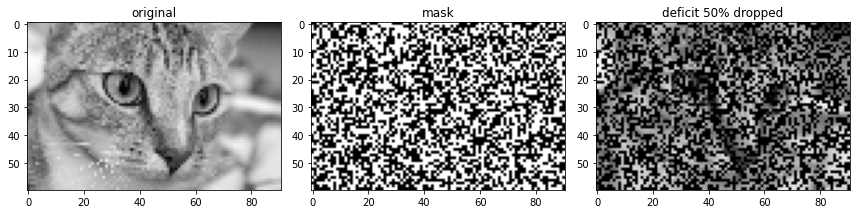

In [3]:
from skimage import io, data
from skimage import color

# prepare images for further testing
original_img = np.asarray(255*color.rgb2gray(data.chelsea()[::5,::5]), dtype=np.uint8)

drop_ratio = 0.5
deficit_img, mask = make_deficit_image(original_img, drop_ratio)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('original')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('mask')

plt.subplot(1, 3, 3)
plt.imshow(deficit_img, cmap='gray')
plt.title('deficit {0:.0f}% dropped'.format(drop_ratio * 100))

plt.tight_layout()

# Inpainting by DCT and k-SVD

In [4]:
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

import sys
sys.path.append('..')
from spmimage.decomposition import KSVD
from spmimage.decomposition import sparse_encode_with_mask, generate_dct_dictionary

In [5]:
# common functions
def extract_and_flatten(img:np.ndarray, patch_size:int) -> np.ndarray:
    patches = extract_patches_2d(img, (patch_size, patch_size))
    return patches.reshape(patches.shape[0], -1).astype(np.float64)

def img_sparse_encode_with_mask(img, H, k0, mask, patch_size):
    Y = extract_and_flatten(img, patch_size)
    M = extract_and_flatten(mask, patch_size)
    W = sparse_encode_with_mask(Y, H, M, algorithm='omp', n_nonzero_coefs=k0)
    return W

def reconstruct_image(img, W, H, patch_size):
    recon_patches = (np.dot(W, H)).reshape((-1, patch_size, patch_size))
    recon_img = reconstruct_from_patches_2d(recon_patches, img.shape)
    return recon_img

In [6]:
def generate_ksvd_dictionary(img, k0, patch_size):    
    n_components = patch_size**2
    dict_init = generate_dct_dictionary(n_components, patch_size)
    X = extract_and_flatten(img, patch_size)
    X = X[np.random.permutation(len(X))][:3000]
    model = KSVD(n_components=n_components, transform_n_nonzero_coefs=k0, max_iter=10, missing_value=0, method='approximate', dict_init=dict_init)        
    model.fit(X)
    return model.components_

## Reconstruction

In [7]:
# constants for reconstruction
patch_size = 8
n_components = patch_size ** 2
k0 = 3

In [8]:
%%time

# DCT
dct_dict = generate_dct_dictionary(n_components, patch_size)
dct_code = img_sparse_encode_with_mask(deficit_img, dct_dict, k0, mask, patch_size)
dct_reconstruct_img = reconstruct_image(deficit_img, dct_code, dct_dict, patch_size)

CPU times: user 3.02 s, sys: 292 ms, total: 3.31 s
Wall time: 1.76 s


In [9]:
%%time

# k-SVD
ksvd_dict= generate_ksvd_dictionary(deficit_img, k0, patch_size)
ksvd_code = img_sparse_encode_with_mask(deficit_img, ksvd_dict, k0, mask, patch_size)
ksvd_reconstruct_img = reconstruct_image(deficit_img, ksvd_code, ksvd_dict, patch_size)

CPU times: user 23.8 s, sys: 2.31 s, total: 26.1 s
Wall time: 12.6 s


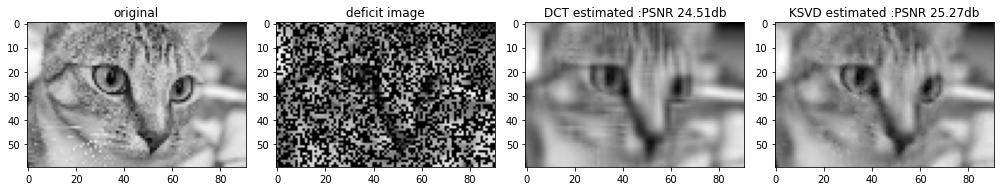

In [10]:
from skimage.metrics import peak_signal_noise_ratio

dct_psnr = peak_signal_noise_ratio(original_img, dct_reconstruct_img.astype(np.uint8))
ksvd_psnr = peak_signal_noise_ratio(original_img, ksvd_reconstruct_img.astype(np.uint8))

plt.figure(figsize=(14, 8))

plt.subplot(1, 4, 1)
plt.imshow(original_img, cmap='gray')
plt.title('original')

plt.subplot(1, 4, 2)
plt.imshow(deficit_img, cmap='gray')
plt.title('deficit image')

plt.subplot(1, 4, 3)
plt.imshow(dct_reconstruct_img, cmap='gray')
plt.title('DCT estimated :PSNR {0:.2f}db'.format(dct_psnr))

plt.subplot(1, 4, 4)
plt.imshow(ksvd_reconstruct_img, cmap='gray')
plt.title('KSVD estimated :PSNR {0:.2f}db'.format(ksvd_psnr))

plt.tight_layout()

### DCT and k-SVD dictionary 

CPU times: user 1.06 s, sys: 18.6 ms, total: 1.08 s
Wall time: 1.08 s


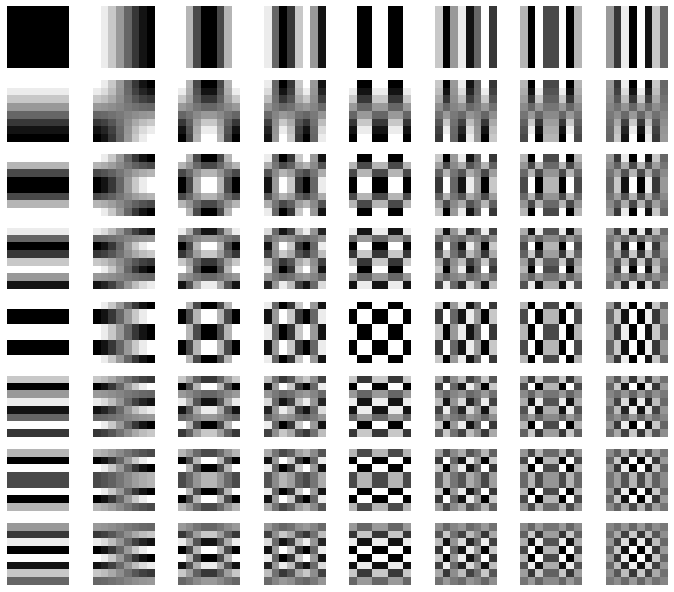

In [11]:
%%time

# DCT dictionary
n_size = dct_dict.shape[0]
n_cols = 8
n_rows = (n_size // n_cols) + 1

plt.figure(figsize=(12, 12))

for i, p in enumerate(dct_dict):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')
    plt.imshow(p.reshape(patch_size, patch_size), cmap='gray')

CPU times: user 1.18 s, sys: 14.5 ms, total: 1.19 s
Wall time: 1.2 s


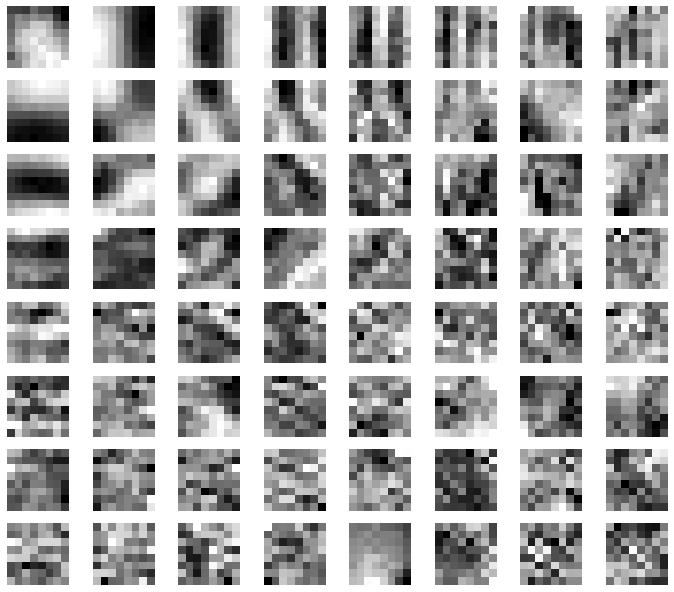

In [12]:
%%time

# KSVD dictionary
n_size = ksvd_dict.shape[0]
n_cols = 8
n_rows = (n_size // n_cols) + 1

plt.figure(figsize=(12, 12))

for i, p in enumerate(ksvd_dict):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')    
    plt.imshow(p.reshape(patch_size, patch_size), cmap='gray')

# Compare with different deficit ratio

## 1. deficit ratio = 0.25

In [13]:
%%time

drop_ratio = 0.25
deficit_img, mask = make_deficit_image(original_img, drop_ratio)

# DCT
dct_dict = generate_dct_dictionary(n_components, patch_size)
dct_code = img_sparse_encode_with_mask(deficit_img, dct_dict, k0, mask, patch_size)
dct_reconstruct_img = reconstruct_image(deficit_img, dct_code, dct_dict, patch_size)

# k-SVD
ksvd_dict= generate_ksvd_dictionary(deficit_img, k0, patch_size)
ksvd_code = img_sparse_encode_with_mask(deficit_img, ksvd_dict, k0, mask, patch_size)
ksvd_reconstruct_img = reconstruct_image(deficit_img, ksvd_code, ksvd_dict, patch_size)

print("DCT PSNR:", peak_signal_noise_ratio(original_img, dct_reconstruct_img.astype(np.uint8)))
print("KSVD PSNR:", peak_signal_noise_ratio(original_img, ksvd_reconstruct_img.astype(np.uint8)))

DCT PSNR: 24.80787319052347
KSVD PSNR: 26.28846662557382
CPU times: user 27.9 s, sys: 2.61 s, total: 30.5 s
Wall time: 14.8 s


## 2. deficit ratio = 0.5

In [14]:
%%time

drop_ratio = 0.5
deficit_img, mask = make_deficit_image(original_img, drop_ratio)

# DCT
dct_dict = generate_dct_dictionary(n_components, patch_size)
dct_code = img_sparse_encode_with_mask(deficit_img, dct_dict, k0, mask, patch_size)
dct_reconstruct_img = reconstruct_image(deficit_img, dct_code, dct_dict, patch_size)

# k-SVD
ksvd_dict= generate_ksvd_dictionary(deficit_img, k0, patch_size)
ksvd_code = img_sparse_encode_with_mask(deficit_img, ksvd_dict, k0, mask, patch_size)
ksvd_reconstruct_img = reconstruct_image(deficit_img, ksvd_code, ksvd_dict, patch_size)

print("DCT PSNR:", peak_signal_noise_ratio(original_img, dct_reconstruct_img.astype(np.uint8)))
print("KSVD PSNR:", peak_signal_noise_ratio(original_img, ksvd_reconstruct_img.astype(np.uint8)))

DCT PSNR: 24.636010913984883
KSVD PSNR: 25.38645052537084
CPU times: user 27.5 s, sys: 2.56 s, total: 30.1 s
Wall time: 14.5 s


## 3. deficit ratio = 0.75

In [15]:
%%time

drop_ratio = 0.75
deficit_img, mask = make_deficit_image(original_img, drop_ratio)

# DCT
dct_dict = generate_dct_dictionary(n_components, patch_size)
dct_code = img_sparse_encode_with_mask(deficit_img, dct_dict, k0, mask, patch_size)
dct_reconstruct_img = reconstruct_image(deficit_img, dct_code, dct_dict, patch_size)

# k-SVD
ksvd_dict= generate_ksvd_dictionary(deficit_img, k0, patch_size)
ksvd_code = img_sparse_encode_with_mask(deficit_img, ksvd_dict, k0, mask, patch_size)
ksvd_reconstruct_img = reconstruct_image(deficit_img, ksvd_code, ksvd_dict, patch_size)

print("DCT PSNR:", peak_signal_noise_ratio(original_img, dct_reconstruct_img.astype(np.uint8)))
print("KSVD PSNR:", peak_signal_noise_ratio(original_img, ksvd_reconstruct_img.astype(np.uint8)))

DCT PSNR: 23.577203243048153
KSVD PSNR: 23.388478151909897
CPU times: user 27.1 s, sys: 2.57 s, total: 29.7 s
Wall time: 14.4 s
